# Cost Functions and Solutions To the Optimization Problem
Unlike the least-squares problem for linear regression, no one has yet found a closed-form solution to the optimization problem presented by logistic regression. But even if one exists, the computation would no doubt be so complex that we'd be better off using some sort of approximation method instead.

Recall the cost function for linear regression: <br/><br/>
$SSE = \Sigma_i(y_i - \hat{y}_i)^2 = \Sigma_i(y_i - (\beta_0 + \beta_1x_{i1} + ... + \beta_nx_{in}))^2$.

This function, $SSE(\vec{\beta})$, is convex.

If we plug in our new logistic equation for $\hat{y}$, we get: <br/><br/>
$SSE_{log} = \Sigma_i(y_i - \hat{y}_i)^2 = \Sigma_i\left(y_i - \left(\frac{1}{1+e^{-(\beta_0 + \beta_1x_{i1} + ... + \beta_nx_{in})}}\right)\right)^2$.

## However... 
*This* function, $SSE_{log}(\vec{\beta})$, is [**not** convex](https://towardsdatascience.com/why-not-mse-as-a-loss-function-for-logistic-regression-589816b5e03c).

That means that, if we tried to use gradient descent or some other approximation method that looks for the minimum of this function, we could easily find a local rather than a global minimum.

## The Good News is... 
We can use **log-loss** instead:

$\mathcal{L}(\vec{y}, \hat{\vec{y}}) = -\frac{1}{N}\Sigma^N_{i=1}\left(y_iln(\hat{y}_i)+(1-y_i)ln(1-\hat{y}_i)\right)$,

where $\hat{y}_i$ is the probability that $(x_{i1}, ... , x_{in})$ belongs to **class 1**.

**Additional resources on the log-loss function**:

https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

http://wiki.fast.ai/index.php/Log_Loss

## Great.. we have a cost function for log reg but how do we intepret our outputs now? 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

# For our modeling steps
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression,\
LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, KFold,\
cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report


# For demonstrative pruposes
from scipy.special import logit, expit
from sklearn import datasets

In [2]:
# glass identification dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
col_names = ['id','ri','na','mg','al','si','k','ca','ba','fe','glass_type']
glass = pd.read_csv(url, names=col_names, index_col='id')
glass.sort_values('al', inplace=True)
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type
id,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1


In [3]:
# types 1, 2, 3 are window glass
# types 5, 6, 7 are household glass
glass['household'] = glass.glass_type.map({1:0, 2:0, 3:0, 5:1, 6:1, 7:1})
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,household
id,,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1,0
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6,1
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1,0


## Train Logistic Regression

In [4]:
# fit a logistic regression model and store the class predictions

logreg = LogisticRegression(random_state=42)
feature_cols = ['al']
X = glass[feature_cols]
y = glass.household
logreg.fit(X, y)
glass['household_pred_class'] = logreg.predict(X)

## Interpreting Logistic Regression Coefficients

In [5]:
logreg.coef_

array([[3.11517927]])

How do we interpret the coefficients of a logistic regression? For a linear regression, the situaton was like this:

- Linear Regression: We construct the best-fit line and get a set of coefficients. Suppose $\beta_1 = k$. In that case we would expect a 1-unit change in $x_1$ to produce a $k$-unit change in $y$.

- Logistic Regression: We find the coefficients of the best-fit line by some approximation method. Suppose $\beta_1 = k$. In that case we would expect a 1-unit change in $x_1$ to produce a $k$-unit change (not in $y$ but) in $ln\left(\frac{y}{1-y}\right)$.

We have:

$\ln\left(\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}\right) = \ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right) + k$.

Exponentiating both sides:

$\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)} = e^{\ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right) + k}$ <br/><br/> $\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}= e^{\ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right)}\cdot e^k$ <br/><br/> $\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}= e^k\cdot\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}$

That is, the odds ratio at $x_1+1$ has increased by a factor of $e^k$ relative to the odds ratio at $x_1$.

For more on interpretation, see [this page](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/binary-logistic-regression/interpret-the-results/all-statistics-and-graphs/coefficients/).

In [6]:
# examine the intercept

logodds = logreg.intercept_
logodds

array([-6.00934605])

> **Interpretation:** For an 'al' value of 0, the log-odds of 'household' is -6.01.

In [7]:
odds = np.exp(logodds)
odds

array([0.00245569])

In [8]:
prob = odds / (1 + odds)
prob

array([0.00244968])

# Complete Logistic Regression Walk-thru 

In [9]:
df = pd.read_csv('data/adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [10]:
df['country'] = df['country'].replace(' ?',np.nan)
df['workclass'] = df['workclass'].replace(' ?',np.nan)
df['occupation'] = df['occupation'].replace(' ?',np.nan)

df.dropna(how='any',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   fnlwgt          30162 non-null  int64 
 3   education       30162 non-null  object
 4   education-num   30162 non-null  int64 
 5   marital-status  30162 non-null  object
 6   occupation      30162 non-null  object
 7   relationship    30162 non-null  object
 8   race            30162 non-null  object
 9   sex             30162 non-null  object
 10  capital-gain    30162 non-null  int64 
 11  capital-loss    30162 non-null  int64 
 12  hours-per-week  30162 non-null  int64 
 13  country         30162 non-null  object
 14  salary          30162 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [11]:
salary_map = {' <=50K':1, ' >50K':0}
df['salary'] = df['salary'].map(salary_map).astype(int)

<AxesSubplot:xlabel='salary', ylabel='count'>

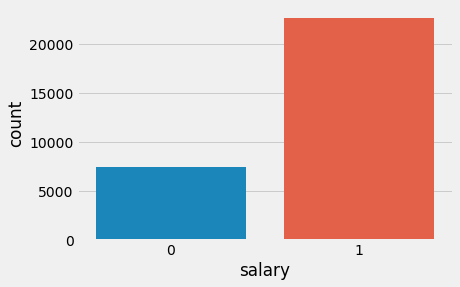

In [12]:
#let's look at a countplot to visualize our new dependent variable 
sns.countplot(x='salary', data=df)

/Users/amberyandow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sex', ylabel='count'>

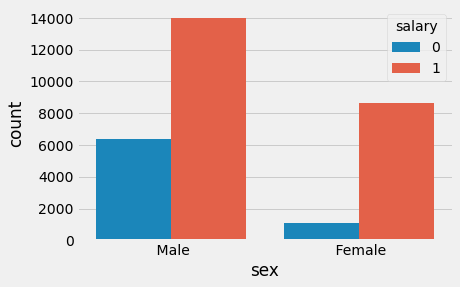

In [13]:
sns.countplot(df['sex'], hue=df['salary'])

## Splitting into train/test sets 

In [14]:
X = df.drop(['salary'], axis=1)
y = df['salary']

split_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=split_size,random_state=0)

## One Hot Encoding our categorical variables 
### Training set first - need to fit and transform 

In [15]:
# Taking in other features (category)
ohe = OneHotEncoder(drop='first')
dummies = ohe.fit_transform(X_train[['workclass', 'education', 'marital-status', 'occupation',
                                    'relationship', 'race', 'sex', 'country']])

# Getting a DF
dummies_df = pd.DataFrame(dummies.todense(), columns=ohe.get_feature_names(),
                         index=X_train.index)

# What we'll feed int our model
X_train_df = pd.concat([X_train[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
                                'hours-per-week']], dummies_df], axis=1)
X_train_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,x0_ Local-gov,x0_ Private,x0_ Self-emp-inc,x0_ Self-emp-not-inc,...,x7_ Portugal,x7_ Puerto-Rico,x7_ Scotland,x7_ South,x7_ Taiwan,x7_ Thailand,x7_ Trinadad&Tobago,x7_ United-States,x7_ Vietnam,x7_ Yugoslavia
15977,44,222978,9,0,1504,40,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13574,32,83253,10,0,0,60,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23210,30,327825,9,0,0,32,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9284,23,109952,10,0,0,60,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8841,54,204325,10,0,0,52,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Encoding our test set - only transform 

In [16]:
# Note the same transformation (not FIT) to match structure
test_dummies = ohe.transform(X_test[['workclass', 'education', 'marital-status', 'occupation',
                                    'relationship', 'race', 'sex', 'country']])
test_df = pd.DataFrame(test_dummies.todense(), columns=ohe.get_feature_names(),
                       index=X_test.index)
X_test_df = pd.concat([X_test[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
                                'hours-per-week']], test_df], axis=1)

## First Model 

In [17]:
lg1 = LogisticRegression()
lg1.fit(X_train_df, y_train)

LogisticRegression()

In [18]:
#How did our training data do? 
lg1.score(X_train_df, y_train)

0.7942499881589542

Evaluate how well the model generalizes with cross-validation (only training data). _Remember_,  cross-validation works like this: First I'll partition my training data into $k$-many *folds*. Then I'll train a model on $k-1$ of those folds and "test" it on the remaining fold. I'll do this for all possible divisions of my $k$ folds into $k-1$ training folds and a single "testing" fold. Since there are $k\choose 1$$=k$-many ways of doing this, I'll be building $k$-many models!

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [19]:
cv_results = cross_validate(
                X=X_train_df, 
                y=y_train,
                estimator=lg1, 
                cv=10,
                scoring='accuracy',
                return_train_score=True
)

In [20]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])

In [21]:
cv_results 

{'fit_time': array([0.16150284, 0.16550589, 0.17413878, 0.20070982, 0.17020321,
        0.17748904, 0.16900682, 0.14332819, 0.2173171 , 0.18080783]),
 'score_time': array([0.00329232, 0.00412798, 0.00307202, 0.0032692 , 0.00351477,
        0.00343609, 0.00340819, 0.0032239 , 0.00373483, 0.00363302]),
 'test_score': array([0.7907197 , 0.79308712, 0.79024621, 0.7877783 , 0.79441023,
        0.80625296, 0.79819991, 0.79725249, 0.79488394, 0.79062056]),
 'train_score': array([0.79458976, 0.7944845 , 0.79458976, 0.79465319, 0.79417956,
        0.79296916, 0.7938638 , 0.7938638 , 0.79323229, 0.79454794])}

## Let's see how the model performs on our test data 

In [22]:
#predictions
prediction = lg1.predict(X_test_df)
prediction

array([1, 1, 1, ..., 0, 1, 1])

In [23]:
print('Accuracy Score:')
print(accuracy_score(y_test, prediction))

print('-'*40)
print('Confusion Matrix:')
print(confusion_matrix(y_test, prediction))

Accuracy Score:
0.7848381036578628
----------------------------------------
Confusion Matrix:
[[ 581 1704]
 [ 243 6521]]


## What are we actually trying to determine here? 

## Review: Bias-Variance tradeoff

![](https://miro.medium.com/max/700/1*oO0KYF7Z84nePqfsJ9E0WQ.png)

The important idea here is that there is a *trade-off*: If we have too few data in our sample (training set), or too few predictors, we run the risk of high *bias*, i.e. an underfit model. On the other hand, if we have too many predictors (especially ones that are collinear), we run the risk of high *variance*, i.e. an overfit model.

### Underfitting 
> Underfit models fail to capture all of the information in the data
* low complexity --> high bias, low variance
* training error: large
* testing error: large

### Overfitting 
> Overfit models fit to the noise in the data and fail to generalize
* high complexity --> low bias, high variance
* training error: low
* testing error: large

**We use training, validating and testing to help us understand if our model is over/underfitting:** 
Roughly:
- Training data is for building the model;
- Validation data is for *tweaking* the model;
- Testing data is for evaluating the model on unseen data.
<br/>

- Think of **training** data as what you study for a test
- Think of **validation** data is using a practice test (note sometimes called **dev**)
- Think of **testing** data as what you use to judge the model
    - A **holdout** set is when your test dataset is never used for training (unlike in cross-validation)
    

## If our model is over/underfitting... 

### A class imbalance in most likely to result in underfitting... why? 

In [26]:
y_train.value_counts()

1    15890
0     5223
Name: salary, dtype: int64

In [24]:
#smote
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_df, y_train) 
print(pd.Series(y_train_resampled).value_counts())

1    15890
0    15890
Name: salary, dtype: int64


In [27]:
#train on resampled data 
lg2 = LogisticRegression()
lg2.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [28]:
lg2.score(X_train_resampled, y_train_resampled)

0.6167715544367527

## Ugh... it got worse... why? 

## If our model is overfitting... 
### Regularization could help! 

Again, complex models are very flexible in the patterns that they can model but this also means that they can easily find patterns that are simply statistical flukes of one particular dataset rather than patterns reflective of the underlying data-generating process.

When a model has large weights, the model is "too confident". This translates to a model with high variance which puts it in danger of overfitting! We need to punish large (confident) weights by contributing them to the error function

**Some Types of Regularization:**

1. Reducing the number of features
2. Increasing the amount of data
3. Popular techniques: Ridge, Lasso, Elastic Net

## The Strategy Behind Ridge / Lasso / Elastic Net

Overfit models overestimate the relevance that predictors have for a target. Thus overfit models tend to have **overly large coefficients**. 

Generally, overfitting models come from a result of high model variance. High model variance can be caused by:

- having irrelevant or too many predictors
- multicollinearity
- large coefficients

Regularization is about introducing a factor into our model designed to enforce the structure that the coefficients stay small, by _penalizing_ the ones that get too large.

That is, we'll alter our loss function so that the goal now is not merely to minimize the difference between actual values and our model's predicted values. Rather, we'll add in a term to our loss function that represents the sizes of the coefficients.

### Lasso: L1 Regularization - Absolute Value
- Tend to get sparse vectors (small weights go to 0)
- Reduce number of weights
- Good feature selection to pick out importance

$$ J(W,b) = -\dfrac{1}{m} \sum^m_{i=1}\big[\mathcal{L}(\hat y_i, y_i)+ \dfrac{\lambda}{m}|w_i| \big]$$

### Ridge: L2 Regularization - Squared Value

- Not sparse vectors (weights homogeneous & small)
- Tends to give better results for training

    
$$ J(W,b) = -\dfrac{1}{m} \sum^m_{i=1}\big[\mathcal{L}(\hat y_i, y_i)+ \dfrac{\lambda}{m}w_i^2 \big]$$

### When should you use L1 and L2 Regularization? 
* **L2**
 - when you have features with high multicollinearity
 - reduce model complexity
 - features with large coefficients(high bias)
 
* **L1**
 - when you have a lot of small coefficients
 - when you have LOTS of features
 - Feature selection 
 
 ![](https://hackernoon.com/hn-images/0*Hb81qZ91t-kZg2eo.png)

## Logistic Regression has regularization already built in 
[Let's check it out](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

### We could run a for loop to iterate over a list of possible C values to see which is best for our model 

In [29]:
C = [100, 10, 1, .1, .001]
for c in C:
    lg3 = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    lg3.fit(X_train_df, y_train)
    print('C:', c)
    print('Training accuracy:', lg3.score(X_train_df, y_train))
    print('Test accuracy:', lg3.score(X_test_df, y_test))
    print('')

C: 100
Training accuracy: 0.8519395633022309
Test accuracy: 0.8423030169079456

C: 10
Training accuracy: 0.8525079335006868
Test accuracy: 0.8415294507680406

C: 1
Training accuracy: 0.8521763842182541
Test accuracy: 0.8430765830478506

C: 0.1
Training accuracy: 0.8492871690427699
Test accuracy: 0.8426345452536191

C: 0.001
Training accuracy: 0.8008809738076067
Test accuracy: 0.7903635760857554



## Other Hyperparameters 
### LogisticRegression has several optional parameters that define the behavior of the model and approach: 

**penalty**- is a string ('l2' by default) that decides whether there is regularization and which approach to use. Other options are 'l1', 'elasticnet', and 'none'.

**dual**- is a Boolean (False by default) that decides whether to use primal (when False) or dual formulation (when True).

**tol**- is a floating-point number (0.0001 by default) that defines the tolerance for stopping the procedure.

**C**- is a positive floating-point number (1.0 by default) that defines the relative strength of regularization. Smaller values indicate stronger regularization.

**fit_intercept**- is a Boolean (True by default) that decides whether to calculate the intercept 𝑏₀ (when True) or consider it equal to zero (when False).

**intercept_scaling**- is a floating-point number (1.0 by default) that defines the scaling of the intercept 𝑏₀.

**class_weight**- is a dictionary, 'balanced', or None (default) that defines the weights related to each class. When None, all classes have the weight one.

**random_state**- is an integer, an instance of numpy.RandomState, or None (default) that defines what pseudo-random number generator to use.

**solver**- is a string ('liblinear' by default) that decides what solver to use for fitting the model. Other options are 'newton-cg', 'lbfgs', 'sag', and 'saga'.

**max_iter**- is an integer (100 by default) that defines the maximum number of iterations by the solver during model fitting.

**multi_class**- is a string ('ovr' by default) that decides the approach to use for handling multiple classes. Other options are 'multinomial' and 'auto'.

**verbose**- is a non-negative integer (0 by default) that defines the verbosity for the 'liblinear' and 'lbfgs' solvers.

**warm_start**- is a Boolean (False by default) that decides whether to reuse the previously obtained solution.

**n_jobs**- is an integer or None (default) that defines the number of parallel processes to use. None usually means to use one core, while -1 means to use all available cores.

**l1_ratio**- is either a floating-point number between zero and one or None (default). It defines the relative importance of the L1 part in the elastic-net regularization.

#### Warning: 
**You should carefully match the solver and regularization method for several reasons:**

'liblinear' solver doesn’t work without regularization. <br/>
'newton-cg', 'sag', 'saga', and 'lbfgs' don’t support L1 regularization. <br/>
'saga' is the only solver that supports elastic-net regularization.

## Pros and Cons of Logistic Regression 

Advantages of logistic regression:

- Highly interpretable (if you remember how)
- Model training and prediction are fast
- Not many parameters to tune
- Can perform well with a small number of observations
- Outputs well-calibrated predicted probabilities

Disadvantages of logistic regression:

- Presumes a linear relationship between the features and the log-odds of the response
- Performance is (generally) not competitive with the best supervised learning methods
- Can't automatically learn feature interactions

## Review: 
- Bias-Variance tradeoff is essential for optimizing all machine learning models 
- Training, validating, testing confirms if our model is overfitting 
- Classification metrics help to understand if we should prioritize precision/recall/f1 and give us specifics about where our model is going wrong
- Hyperparameter tuning allows us to adjust our models to fit the data 